In [2]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchinfo import summary

In [3]:
# 이미지 데이터 준비
filename = '../data/img/img_04_zizel.jpg'

In [4]:
# color 이미지
imgNP = cv2.imread(filename)/255
imgNP2 = cv2.resize(imgNP, (50,50))
print(imgNP.shape, imgNP.ndim, '---',imgNP2.shape, imgNP2.ndim)

# gray 이미지
grayNP = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)/255
grayNP2 = cv2.resize(grayNP, (50, 50))
print(grayNP.shape, grayNP.ndim, '---', grayNP2.shape, grayNP2.ndim)

(1120, 720, 3) 3 --- (50, 50, 3) 3
(1120, 720) 2 --- (50, 50) 2


In [5]:
# numpy --> floattensor 변환
colorT = torch.FloatTensor(imgNP2)
grayT = torch.FloatTensor(grayNP2)
print(colorT.shape, colorT.ndim, '---' ,grayT.shape, grayT.ndim)

torch.Size([50, 50, 3]) 3 --- torch.Size([50, 50]) 2


In [6]:
# pytorch 이미지 데이터 형식 (C, H, W) 
# 그래서 C가 앞으로 오도록 당겨주어야함
colorT = colorT.permute(2, 0, 1)
grayT.unsqueeze_(dim=0)  
print(colorT.shape, colorT.ndim, '---' ,grayT.shape, grayT.ndim)

torch.Size([3, 50, 50]) 3 --- torch.Size([1, 50, 50]) 3


####  ===> CNN layer 살펴보기

In [7]:
### ===> 이미지 데이터로 Conv2D
### [1] 흑백 이미지
conLayer = nn.Conv2d(in_channels=1, out_channels = 5, kernel_size = 3, stride = 1, padding = 'same') # 입력 출력 shape 다름
# conLayer = nn.Conv2d(in_channels=1, out_channels = 5, kernel_size = 5, stride = 1, padding = 0) # 입력 출력 shape 다름
# out_channels => 필터개수이다. 필터 개수만큼 FeatureMap이 생성된다.

conLayer2 = nn.Conv2d(in_channels=5, out_channels = 3, kernel_size = 3, stride = 1, padding = 'same') # 입력 출력 shape 동일
# conLayer3 = nn.Conv2d(in_channels=3, out_channels =3, kernel_size = 5, stride = 1, padding = (2,1))
print(conLayer, conLayer2, sep= '\n')

Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=same)
Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)


In [8]:
output = conLayer(grayT)
output2 = conLayer2(output)
print(grayT.shape, output.shape, output2.shape)

torch.Size([1, 50, 50]) torch.Size([5, 50, 50]) torch.Size([3, 50, 50])


결론은 알겠는데 왜 값 자체가 46, 46이 되는지를 모르겠다

In [9]:
### ===> polling layer : conv층에서 추출한 특징을 다운샘플링 진행
### 결과 shape : H,W 줄어듬, C는 그대로
pol1 = nn.MaxPool2d(kernel_size = 3)
pol2 = nn.MaxPool2d(kernel_size = 3, stride = 2)

In [10]:
### convXD + AF => F.relu( )
relu1 = F.relu(output)

output_2 = conLayer2(relu1)
relu2 = F.relu(output_2)

print(relu1.shape, relu2.shape)

torch.Size([5, 50, 50]) torch.Size([3, 50, 50])


In [11]:
# 2번째 Conv2D + AF 결과인 피처맵 전달
fm1 = pol1(relu2)
fm1.shape

torch.Size([3, 16, 16])

In [12]:
fm2 = pol2(relu2)
fm2.shape

torch.Size([3, 24, 24])

### 추출된 feature map 확인

In [13]:
## 구성 : Conv2D + Conv2D + Pooling
print(f'[input] {grayT.shape}')

output1 = conLayer(grayT)
relu1 = F.relu(output1)
print(f'[relu1] {relu1.shape}')

output2 = conLayer2(relu1)
relu2 = F.relu(output2)
print(f'[relu2] {relu2.shape}')

mp1 = pol1(relu2)
print(f'[mp1] {mp1.shape}')

[input] torch.Size([1, 50, 50])
[relu1] torch.Size([5, 50, 50])
[relu2] torch.Size([3, 50, 50])
[mp1] torch.Size([3, 16, 16])


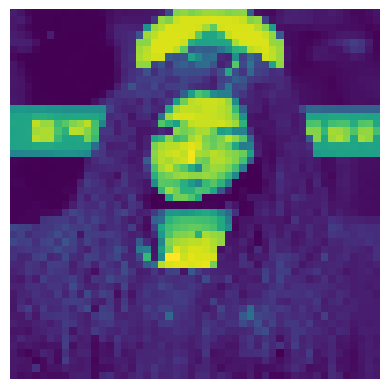

In [14]:
### ===> 시각화
import matplotlib.pyplot as plt

### 입력 그림 : 3D => 2D
plt.imshow(grayT.squeeze(dim=0))
plt.axis('off')
plt.show()

In [15]:
### 첫번째 Conv2D Layer 추출 피처맵
def print_featuremap(fm_tensor, cols, layer_name):
    print(f"[{layer_name} Layer]")
    for idx in range(fm_tensor.shape[0]):
        # print(relu1[idx].shape)
        plt.subplot(1,cols,idx+1)
        plt.imshow(fm_tensor[idx].detach(), cmap = 'gray')
        plt.title(label = f"FeatureMap {idx+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

[first Layer]


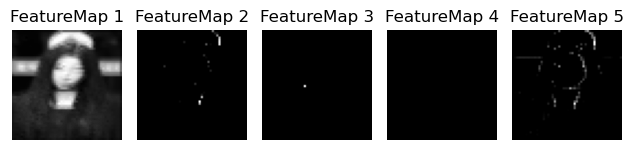

[second Layer]


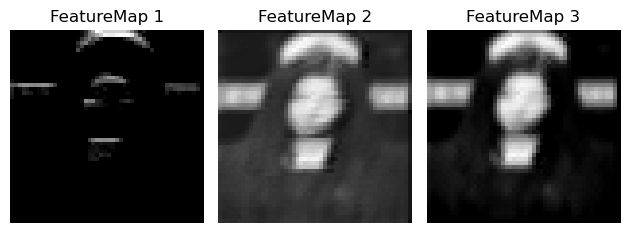

[third Layer]


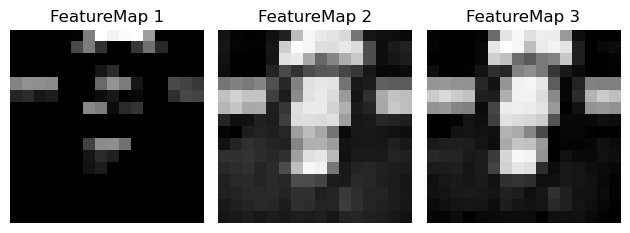

In [16]:
print_featuremap(relu1, 5, 'first')
print_featuremap(relu2, 3, 'second')
print_featuremap(mp1, 3, 'third')